# Master Thesis Notebook

## Setup

In [2]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Choosing the variogram model

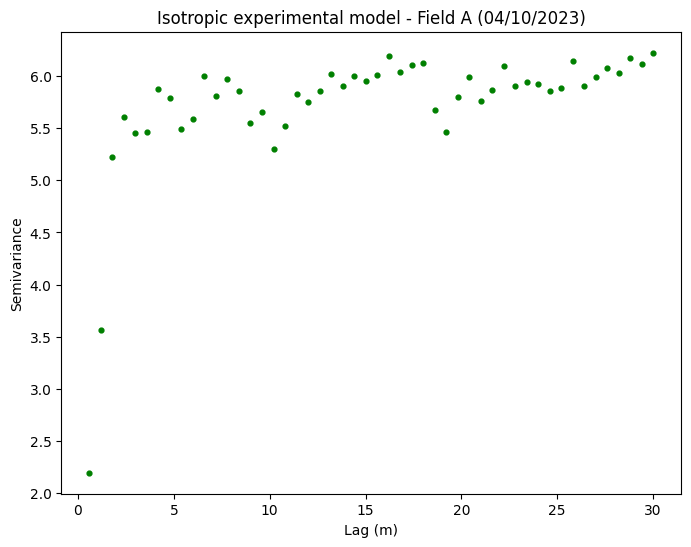

In [3]:
experimental_vario_a = Variogram(resolution=1, field_letter="A", sample_number=6)

experimental_vario_a.determ_experimental_vario() ;
# ; hide output of the cell

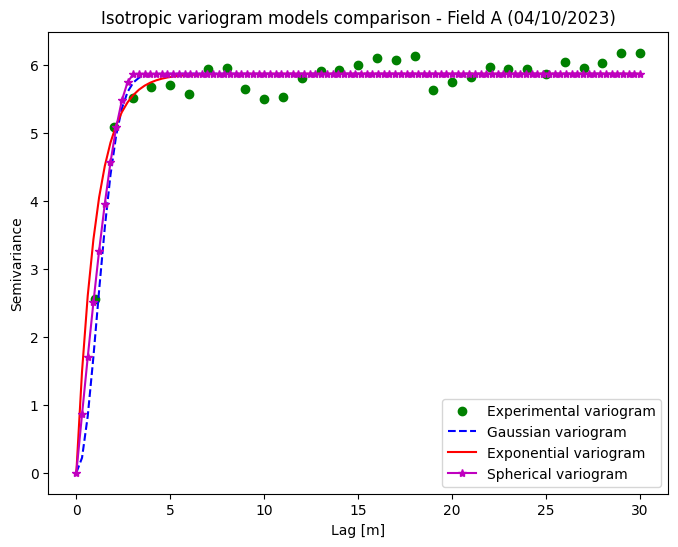

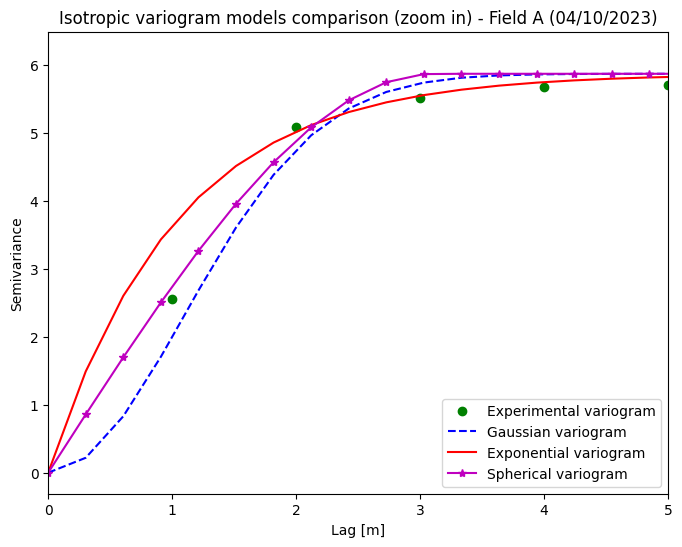

In [4]:
experimental_vario_a.fit_models()

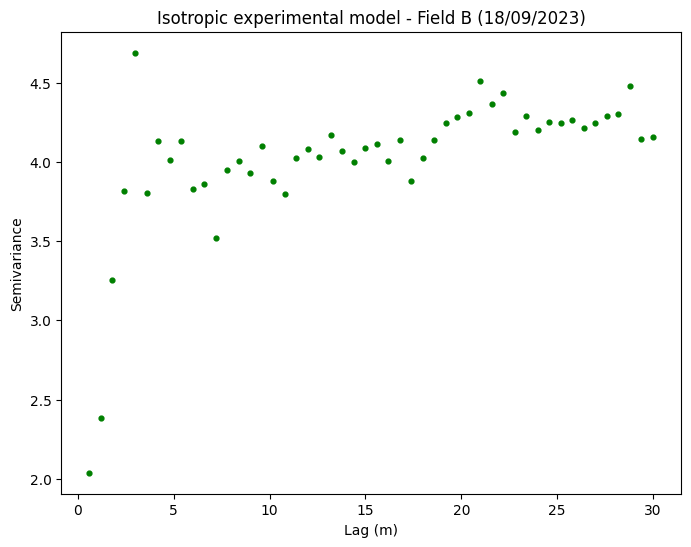

In [7]:
experimental_vario_b = Variogram(resolution=1, field_letter="B", sample_number=5)

experimental_vario_b.determ_experimental_vario() ;

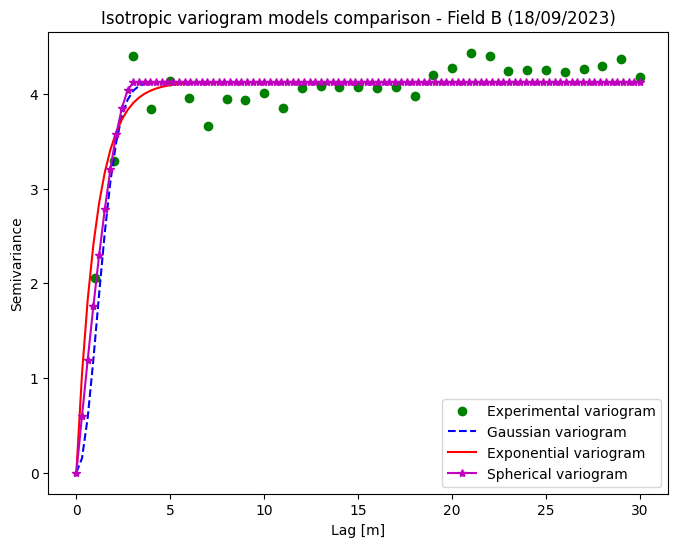

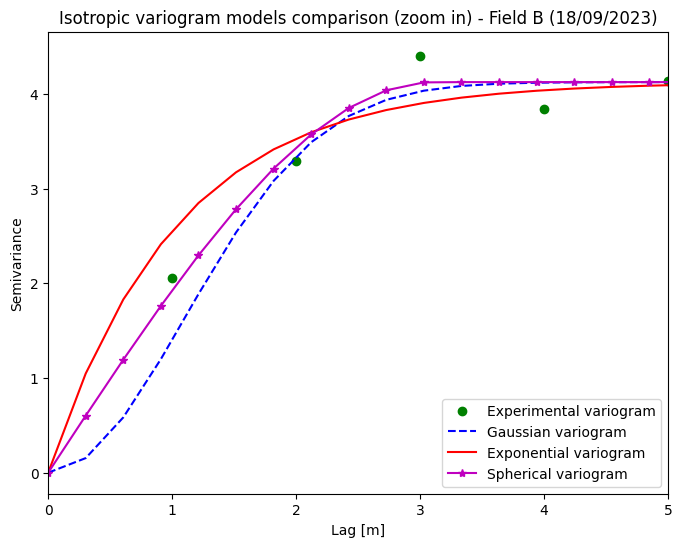

In [8]:
experimental_vario_b.fit_models()

### Raw data

In [18]:
# Instance creation
gpr_a = GprAnalysis(field_letter="A", sample_number=6)  # Sample number [0-11] # A/B
# Instance creation
gpr_b = GprAnalysis(field_letter="B", sample_number=5)  # Sample number [0-11] # A/B

In [19]:
# Raw Sample
gpr_a.plot_raw_data()

OSError: [Errno 22] Invalid argument: 'Data/Drone GPR/Field A\\Vwc-230516-mili.txt'

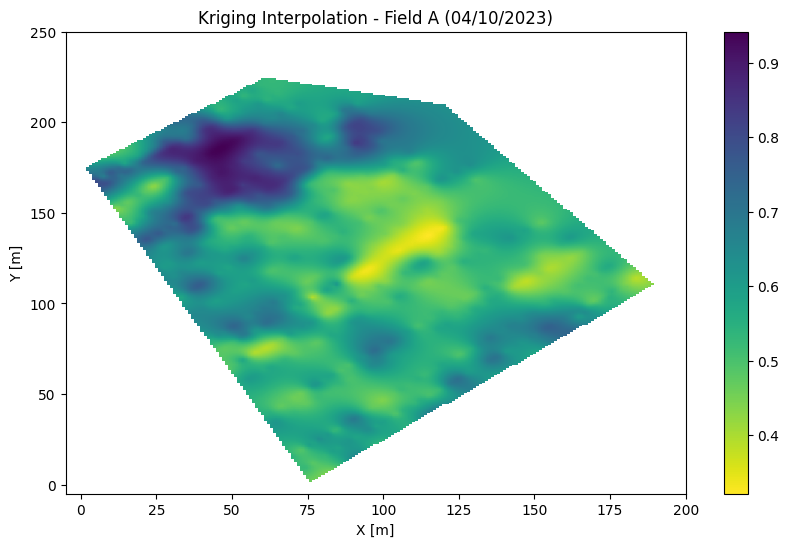

In [11]:
gpr_a.kriging(plot=True)

In [15]:
gpr_b.plot_raw_data()

OSError: [Errno 22] Invalid argument: 'Data/Drone GPR/Field B\\Vwc-230516-bas.txt'

In [ ]:
gpr_b.kriging(plot=True)

In [ ]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

In [ ]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

In [ ]:
gpr_a.zonal_check()

In [ ]:
gpr_b.zonal_check()

## TDR Verification

In [ ]:
GprAnalysis(field_letter="A", sample_number=8).tdr_verification(10)

## Rainfall Analysis

In [ ]:
rf_mr = Rainfall()
rf_mr.plot_data()

## Water Table depth and VWC continuous Analysis

In [ ]:
teros = Teros()
teros.plot_piezo_sampler_locations()

In [ ]:
teros.plot_vwc_evolution()

In [ ]:
wt = WaterTable()
wt.plot_wt_sampler_locations()

In [ ]:
wt.plot_wt_evolution()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


In [ ]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()